# `linearsolve`

<div name="html-admonition" style="font-size: 0.8em">
<input type="button" onclick="location.href='https://translate.google.com/translate?hl=&sl=ja&tl=en&u='+window.location;" value="Google translation" style="color:#ffffff;background-color:#008080; height:25px" onmouseover="this.style.background='#99ccff'" onmouseout="this.style.background='#008080'"/> in English or the language of your choice.
</div><br>

In [1]:
import linearsolve as ls
import numpy as np
import pandas as pd

## 説明

後に続く章では，実物的景気循環(RBC)モデルとNew Keynsianモデル（Dynamic Stochastic General Equilibrium Model，略してDSGEモデルとも呼ばれる）を考える。それらのモデルでは，消費者は効用を最大化し，企業は利潤を最大化する。そのような最適化問題を解き，一般均衡での動学方程式を導出する作業は高度な数学的な知識を要求するため，このサイトの範囲を超えることになる。従って，それぞれのモデルの考えを説明した後，シミュレーションを使いデータとの整合性などを検討する。この章では，そのために使用する`linearsove`というパッケージの使い方を説明する。

実物的景気循環モデルやNew Keynsianモデルの均衡式は複雑な非線形となっており，また将来の変数に対する期待が重要な役割を果たす。従って，次の２つのステップを踏んでシミュレーションをおこなうことになる。
1. 非確率的な定常状態の近傍で**線形近似**をおこない，それぞれの変数を定常状態からのパーセント乖離で表した均衡式に書き直してシミュレーションをおこなう。その際の定常状態からのパーセント乖離で表すことを**対数線形近似**と呼ぶ。（ちなみに，このサイトで扱うNew Keynsianモデルの内生変数は最初から％乖離で表されている。）
1. 様々な均衡を計算する手法が提案されており，その１つに従ってモデルを「解く」。

このプロセスを自動化してくれるのが`linearsolve`（[リンク](https://www.briancjenkins.com/linearsolve/docs/build/html/index.html)）である。２の均衡の計算方法はについては，
`linearsolve`は[Klein (2000)](http://www.sciencedirect.com/science/article/pii/S0165188999000457)を採用している。その詳細については割愛するが，1の対数線形近似について簡単に説明する。

````{note}
`linearsolve`を使用するためには，事前にインストールする必要がある。MacのターミナルやWindowsのAnaconda Promptでは，次のコマンドでインストールすることができる。
```
pip install linearsolve
```
````

### 対数線形近似

$t=0,1,2,..$の離散時間を考えよう。$t$時点での変数$X$を$X_t$とする。産出量や資本ストックなどをイメージすれば良いだろう。さらに次の変数を定義する。
* $X$：$X_t$の定常状態の値
* $x_t\equiv\log\left(\dfrac{X_t}{X}\right)$：$X_t$の定常状態からのパーセント乖離
    * 定常状態（$X_t=X$）では$x_t=0$になることを覚えておこう。

以前，マクロ変数をトレンドと変動（トレンドからの％乖離）に分離する分析をおこなった。その際，$\bar{X}_t$をトレンドとすると，変動は次式で近似できることも説明した。

$$
\frac{X_{t+1}-\bar{X}_t}{\bar{X}_t}\approx\log\left(\frac{X_{t+1}}{\bar{X}_t}\right)
$$

実は，これが正しく対数線形近似の考え方なのである。$X=\bar{X}_t$として，この式を変形すると次のようになる。

$$
\begin{align*}
\frac{X_{t}-X}{X}&\approx\log\left(\frac{X_{t}}{X}\right)\\
\frac{X_{t}}{X}&\approx 1+\log\left(\frac{X_{t}}{X}\right)\\
X_{t}&\approx X(1+x_t)
\end{align*}
$$

この式が$X_t$の対数線形近似となる。更に，$Z_t^a$の線形近似を考えてみよう。$Z^a$を定常状態と置いて上の計算の2行目に$X_t=Z_t^a$と$X=Z^a$を代入してみる。

$$
\begin{align*}
\frac{Z_{t}^a}{Z^a}&\approx 1+\log\left(\frac{Z_{t}^a}{Z^a}\right)\\
&\approx 1+a\log\left(\frac{Z_{t}}{Z}\right)\\
Z_t^a&\approx Z^a(1+az_t)
\end{align*}
$$ (eq:14-linearapprox)

ここで$z_t=\log\left(\dfrac{Z_t}{Z}\right)$は$Z_t$の％乖離を表している。式[](eq:14-linearapprox)が$Z_t^a$の対数線形近似であり，$a=1$の場合を包含する形となっている。

### 例：ソロー・モデル

例として，人口成長も技術進歩もないソロー・モデルの資本蓄積方程式を考えよう（$L=1$を仮定する）。

$$
K_{t+1}=sK_t^a+(1-\delta)K_t
$$

式が示すように，$K_{t+1}$と$K_{t}$は非線形の関係にある。次の変数を定義して，対数線形近似をおこなう。
* $K=\left(\dfrac{s}{\delta}\right)^{\frac{1}{1-a}}$：定常状態
    * $\dfrac{s}{K^{1-a}}=\delta$と書くこともできるが，この関係を下の計算で使う。
* $k_t$：定常状態からのパーセント乖離（「労働者一人当たり資本」ではない。ここでは$K_t$が労働者一人当たり資本と等しい）。

それぞれの項にパーセント乖離の線形近似を適用する。

$$
\begin{align}
K(1+k_{t+1})&=sK^a(1+ak_t)+(1-\delta)K(1+k_t)\\
1+k_{t+1}&=\frac{s}{K^{1-a}}(1+ak_t)+(1-\delta)(1+k_t)\\
&=\delta(1+ak_t)+(1-\delta)(1+k_t)\\
k_{t+1}&=[1-(1-a)\delta]k_t\\
\end{align}
$$

これでパーセント乖離の変数である$k_{t+1}$と$k_{t}$の線形式が導出できた。$k_t$の係数は正の値であり$1$より小さいので，定常状態$0$は安定的だとわかる。

### 例：ショック項があるコブ・ダグラス生産関数

次のコブ・ダグラス生産関数を考えよう。

$$
Y_t=A_tK_t^\alpha
$$

ここで$A_t$はTFPショックと考えることができる。また定常状態は次式で与えられるとしよう。

$$
Y=AK^\alpha
$$

$t$期の生産関数を定常状態の生産関数で除した結果を対数化することで簡単に％乖離を計算できる。

$$
\frac{Y_t}{Y}=\frac{A_t}{A}\left(\frac{K_t}{K}\right)^\alpha
\quad\Rightarrow\quad
y_t = a_t+\alpha k_t
$$

この場合，線形近似ではなく正確な関係を表している。同じ結果を上の[](eq:14-linearapprox)式を使って導出してみよう。

$$
\begin{align*}
Y(1+y_t)&=A(1+a_t)K^\alpha(1+\alpha k_t)\\
1+y_t&=(1+a_t)(1+\alpha k_t)\\
&=1+\alpha k_t+a_t+\alpha a_tk_t\\
y_t&=\alpha k_t+a_t
\end{align*}
$$

最後の行では$\alpha a_tk_t=0$としている。％乖離の積は非常に小さな値であるためであり，[](eq:14-linearapprox)式を導出する上で発生した誤差を表している（誤差は無視できるほど非常に小さい）。

## `linearsolve`の使い方

対数線形近似を理解できたと思うので，`linersolve`を使って次のステップでシミュレーションを進める。
1. モデルのパラメータを`Series`として保存する。
1. 内生変数名とショックの変数名を別々のリストとして保存する。
1. 非確率的な定常状態での均衡条件を返す関数を定義する。
1. `linearsolve.model`を使いシミュレーションのための最終準備（シミュレーションの情報が詰まったオブジェクトを作成）をする。
1. 定常状態の計算。
1. モデルを対数線形近似する。
1. シミュレーション結果の表示。

シミュレーションをおこなう上で２つの変数を区別することも重要となるので次の点を抑えておこう。
* 「ストック変数」，「状態変数」，「先決変数」
    * 資本ストックのように前期までの経済行動で決定され当該期では所与として扱われる変数
* 「フロー変数」，「操作変数」，「コントロール変数」
    * 消費や産出量のように当該期に決定される変数


またシミュレーションのの中で**決定**される変数は全て「内生変数」と呼ぶ。

以下では２つの例を使い具体的にシミュレーションのコードの書き方を説明をする。

## 全要素生産性（TFP）

$A$は全要素生産性（TFP）を表しており，次式に従って変化すると考えよう。

$$
A_{t+1}=A_t^{\rho}e^{u_{t+1}},
\quad 0<\rho<1
$$ (eq:14-tfp)

ここで，底の$e$はネイピア数であり，指数の$u_{t+1}$はショック変数のホワイト・ノイズであり，正規分布に従うと仮定する。

$$
u_{t}\sim\mathcal{N}(0,\sigma^2)
$$

* ストック変数：$A_t$
* フロー変数：なし
* このモデルで決定される変数（内生変数）：$A_t$
* 所与として扱う変数（外生変数，ショック変数）：$u_t$

### ステップ１：パラメータの値

パラメータは$\rho$と$\sigma$の２つだけである。パラメータの値を入れた`Series`を変数`parameter`に割り当てる。

In [2]:
parameters = pd.Series({'rho':0.9,
                        'sigma':0.0078**2})
parameters

rho      0.900000
sigma    0.000061
dtype: float64

ここでは辞書を使って`Series`を作成している。`sigma`の値は日本のTFPに関して計算した数値を設定している。

### ステップ２：変数リスト

内生変数名のリスをを作成する。その際，次の順番で並べる。
* ショック項が**ある**ストック変数（内生変数）の変数名
* ショック項が**ない**ストック変数（内生変数）の変数名
* フロー変数（他の内生変数）の変数名

この例では，ショック項があるストック変数`A`のみとなる。また，リストの要素として含める変数名を`A`としても良いが，計算結果では`A`の対数線形近似の変数が返される。それを見越して，ここでは`a`を使うことにする。

In [3]:
var_names = ['a']

次に，外生的ショックを表す変数名のリストを作成するが，`var_names`と同じ順番に並べる。

In [4]:
shock_names = ['u']

### ステップ３：定常状態での均衡条件の関数

定常状態とは，ショック項が`0`であり，`A`が一定となる状態を指す。このステップでは，定常状態での値を返す関数を作成する。関数名を`equilibrium_equations`とする。この例での定常状態では次の条件を満たしている。

$$
A_{t+1}=A_t,\quad u_t=0
$$

* 引数：
    * `variables_forward`: $t+1$期（来期）の変数
    * `variables_current`: $t$期（当該期）の変数
    * `parameters`：ステップ１で設定したパラメータの値を含む変数`parameters`
* 戻り値：
    * 定常状態での内生変数の値を格納する`Numpy`の`array`

In [5]:
def equilibrium_equations(variables_forward, variables_current, parameters):
    fwd = variables_forward        #1
    
    cur = variables_current        #2
    
    p = parameters                 #3

    tfp = cur['a']**p['rho']/fwd['a']-1   #4
    
    return np.array([tfp])         #5

＜コードの説明＞
* `#1`： t+1期の変数を`fwd`に割り当てる。
* `#2`： t期の変数を`cur`に割り当てる。
* `#3`： ステップ１の`parameters`を`p`に割り当てる。
* `#4`： 定常状態でのTFPの式を使い，左辺が0になるように整理し，その右辺を`tfp`に割り当てる。

    $$
    A_{t+1}=A_t^{\rho}
    \quad\Rightarrow\quad
    0=\frac{A_t^{\rho}}{A_{t+1}}-1
    $$
    
    * 他にも均衡式がある場合は，同じ方法で指定することになる。
    * ステップ４で`equilbirium_equations`関数を単に指定するだけだが， `linearmodels`は`cur`と`fwd`を`Series`として扱うことになるため，変数を`['a']`の形で指定する必要がある。
* `#5`： `#4`の変数を`array`として返す。
    * `#4`以外にも均衡式がある場合は，`#5`に含まれることになる。

### ステップ４：モデルの最終準備（初期化）

`ls`の`model`という関数を使いシミュレーションの最終準備をおこない（初期化し），`tfp_model`に割り当てる。
* 引数：
    * `equations`：ステップ３で定義した関数を指定する。
    * `n_states`：ストック変数の数を指定する。
        * （この例ではストック変数は`A`のみなので`1`を設定する。）
    * `n_exo_state`：ストック変数の中で外生的なショック項をともなう変数の数を指定する。
        * （この例ではストック変数`A`にショック項`v`が存在するので`1`を設定する。）
    * `var_names`：ステップ２で設定した内生変数のリストを指定する。
    * `shock_names`：ステップ２で設定したショック変数のリストを指定する。
    * `parameters`：ステップ１で設定したパラメータの値を含む`Series`を指定する。
* 戻り値：
    * `linearsolve`の`model`オブジェクトが返される。その中に様々な情報が含まれており，それを使いシミュレーションをおこなう。

In [6]:
tfp_model = ls.model(equations = equilibrium_equations,
                     n_states=1,
                     n_exo_states=1,
                     var_names=var_names,
                     shock_names=shock_names,
                     parameters = parameters)

### ステップ５：定常状態の計算

最初に定常状態の値を確認しよう。`tfp_model`のメソッド`compute_ss()`（`ss`は定常状態を指すsteady stateの略）を使うと自動で計算してくれる。その際，引数に計算の初期値をリストとして与える。`linearsolve`が定常値を「計算する」という意味は，定常値を「探す」ということと等しい。その際，探す出発点となる値が「計算の初期値」である。この例では変数が１つなので`[1.1]`のようにする。複数ある場合は，ステップ２で設定した`var_names`の順番に合わせて初期値を並べる必要がある。

In [7]:
tfp_model.compute_ss([1.1])

上のコードを評価すると，`tfp_model`には`.ss`という属性が**追加**され，計算結果は属性`.ss`でアクセスすることが可能である。

In [8]:
tfp_model.ss

a    1.0
dtype: float64

ここで示しているのは，`linearmodels`は`1.1`を出発点として定常値を探し始め，最終的に`1.0`を探し出したということだ。

### ステップ６：モデルを対数線形近似

次にシミュレーションのための対数線形近似をおこなう。`tfp_model`には`.approximate_and_solve()`というメソッドが用意されており，それを評価すると`tfp_model`に対数線形近似の結果が追加される。

In [9]:
tfp_model.approximate_and_solve()

対数線形近似の結果はメソッド`solved()`で表示することができる。

In [10]:
print(tfp_model.solved())

Solution to the log-linear system:

a[t+1] = 0.9·a[t]+u[t+1]


ここで表示された式を考えてみよう。$A_t$の定常状態での値は1であり，式[](eq:14-tfp)を次のように書ける。

$$\frac{A_{t+1}}{1}=\left(\frac{A_{t}}{1}\right)^\rho e^{u_{t+1}}$$

$a_{t}\equiv\log\left(\dfrac{A_{t}}{1}\right)$を使い，この式の両辺を対数化すると

$$
a_{t+1}=\rho a_t+u_{t+1}
$$

となり（$\log(1)=0$を思い出そう），上の式と同じになる。この結果から，上の式は近似ではなく同じ式である事が分かる。

````{note}
`print(tfp_model.solved())`のコードが表示しているのは２行は文字列であり，改行が２回（`\n\n`）入っている。これを利用して次のコードで２行目の式だけを取り出す事ができる。
```
print(tfp_model.solved().split('\n\n')[1])
```
* `split()`は文字列を引数`'\n\n'`で分割し，結果をリストとして返すメソッドである。
* `[1]`はリストの1番目の要素を取り出している（0番目は`Solution to the...`となる）。
````

### ステップ７：シミュレーション結果の表示

#### インパルス反応

`t=0`期は定常状態で`a[0]=0`としよう。更に，`t=1`期にショック項が1％上昇したとしよう（`u[1]=1%`）。この場合，`a[1]=1%`となる事が分かる。これが**インパクト効果**である。インパクト後，ショック項は`0`に張り付いたままとなり，`a`の値は次のように変化することになる。

`a[0]=0`

`a[1]=1%`

`a[2]=0.95a[1]=0.95x1%=0.95%`

`a[3]=0.95a[2]=0.95x0.95x1%=0.9025%`

`a[4]=0.95a[3]=0.95x0.95x0.95x1%=0.857375%`

`......`

時間が経つに連れて徐々に減少することになり，一般的には次の式で表すことができる。

$$
a[t]=0.95^{t-1}\times 1\%,\qquad\quad t=1,2,3,...
$$

この一連の「出力」が**インパルス反応**と呼ばれる。

#### インパルス反応の計算と図示

では，実際にインパルス反応を計算し図示してみよう。ホワイト・ノイズのショック$u_t$のインパルス反応を計算するには，`tfp_model`のメソッド`impulse()`を使う。

* 引数：
    * `T`：シミュレーションのの期間
    * `t0`：何期目にショックが発生するかを指定
    * `shocks`：ショックの大きさ（定常状態からの乖離率，デフォルトは`0.01`）
        * リストとして指定する。例えば，`[0.02]`。
    * `percent`：変数の定常状態からの乖離を％表示にする（`True`/`False`; デフォルトは`False`）
* 戻り値：
    * なし
    * 計算結果は`tfp_model`に辞書として**追加**される。
        * キー：ショック名の`u`
        * 値：ショック変数と内生変数の`DataFrame`
    * 追加された辞書は属性`.irs`（Impulse ReSponseの略）でアクセスできるので，キー`u`を使って`DataFrame`を表示することが可能となる。
    
まずメソッド`.impulse()`で計算しよう。

In [11]:
tfp_model.impulse(T=50, t0=5, percent=True)

次に，属性`.irs`を使って辞書を抽出し，キー`u`を使って`DataFrame`を表示する。

In [12]:
tfp_model.irs['u'].head(9)

,u,a
0,0.0,0.000
1,0.0,0.000
2,0.0,0.000
3,0.0,0.000
4,0.0,0.000
5,1.0,1.000
6,0.0,0.900
7,0.0,0.810
8,0.0,0.729


`5`番目の行のみで`u`が`1.0`になっているのが確認できる。同様に，`a`も`1.0`に跳ね上がっているが，インパクト後は徐々に減少しているのがわかる。

この`DataFrame`をプロットしてみよう。

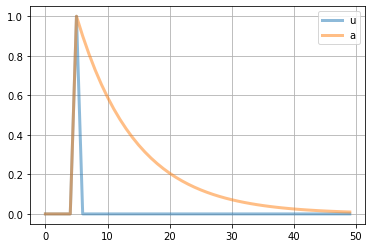

In [13]:
tfp_model.irs['u'].plot(lw=3, alpha=0.5, grid=True)
pass

この図の`a`は`A_t`の定常状態からの％乖離を表していることを思い出そう。`t=0`から`t=4`の５期間はショックがない定常状態である。`t=5`に`2%`の正のショックが発生し，`t=6`以降のショックは`0`に戻っている。一方，`A`の％乖離である`a`はゆっくりと減少し`50`期間過ぎても`0.1%`以上定常状態から乖離している。例えば，一期間を１四半期と考えた場合，ショック項の影響は`45/4=11.25`年経った後でも残っていることになる。persistenceと呼ばれるこのような性質が景気循環を理解する上で重要な鍵となる。

#### コードを１つのセルにまとめる

今までの説明では，それぞれのステップ毎にセル内でコードを書き実行した。しかし，一旦コードにエラーがないと確認できた後は，1つのセルにコードをまとめることを勧める。例えば，パラメーターの値を変えて様々なパターンの結果を確認したいとしよう。1つのセルにコードをまとめると１回のコードの実行で結果を表示できる便利さがある。

定常値
a: 1.000

対数線形近似
a[t+1] = 0.9·a[t]+u[t+1]


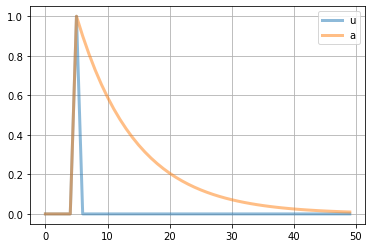

In [36]:
# パラメーターの値
parameters = pd.Series({'rho':0.9,
                        'sigma':0.0078**2})

# 変数のリスト
var_names = ['a']
shock_names = ['u']

# 定常状態での均衡の関数
def equilibrium_equations(variables_forward, variables_current, parameters):
    fwd = variables_forward    
    cur = variables_current
    p = parameters

    tfp = cur['a']**p['rho']/fwd['a']-1
    
    return np.array([tfp])

# モデルの初期化
tfp_model = ls.model(equations = equilibrium_equations,
                     n_states=1,
                     n_exo_states=1,
                     var_names=var_names,
                     shock_names=shock_names,
                     parameters = parameters)

# 定常状態の計算
tfp_model.compute_ss([1.1])
ss = tfp_model.ss
print(f'定常値\n{ss.index[0]}: {ss[0]:.3f}\n')

# 対数線形近似
tfp_model.approximate_and_solve()
print('対数線形近似\n', tfp_model.solved().split('\n\n')[1], sep='')

# インパルス反応の計算
tfp_model.impulse(T=50, t0=5, percent=True)

# プロット
tfp_model.irs['u'].plot(lw=3, alpha=0.5, grid=True)
pass

#### 確率的シミュレーション

インパルス反応は，ある一期間のみにショック項が変化する場合の分析となる。一つのショックの時系列的な効果を検討する上では有用な手法である。一方で，実際経済ではショックが断続的もしくは連続的に発生していると考えることができる。そのような状況を捉えた**確率的シミュレーション**をおこなおうというのが，ここでの目的である。

`linearmodels`には，そのためのメソッド`.stoch_sim()`が実装されている。
* 主な引数：
    1. `seed` (オプション): `Numpy.random`を使いランダム変数を発生させるが，`seed`とはランダム変数の「種」という意味である。`seed`に同じ数字を設定すると同じランダム変数が生成されることになる。同じ「種」からは同じランダム変数を発生させることができる，ということである。
    1. `T`：シミュレーションの期間（デフォルトは51）
    1. `cov_mat`：ショック変数の分散共分散行列
        * ショック変数が１つの場合は分散を`[[0.5]]`のようにリストのリストで設定する。（デフォルトは`[[1]]`）
        * ショック変数が複数の場合は`[[0.5,0.1],[0.1,2]]`のようなパターンで設定する。（デフォルトは`[[1,0],[0,1]]`）この例で，`0.5`と`2`が２つのショック項の分散であり，`0.1`が共分散となる。
    1. `percent`：変数の定常状態からの乖離を％表示にする（`True`/`False`; デフォルトは`False`）
*　戻り値：
    * なし
    * 結果は`tfp_model`に`DataFrame`として追加され，属性`simulated`で抽出できる。

In [14]:
tfp_model.stoch_sim(seed=12345, T=200,
                    cov_mat=[[parameters['sigma']]],
                    percent=True)

結果の一部を表示してみる。

In [15]:
tfp_model.simulated.head()

,u,a
0,1.362842,2.011740
1,-1.099992,0.710574
2,-0.295028,0.344488
3,-0.269740,0.040299
4,0.296449,0.332718


図示してみよう。

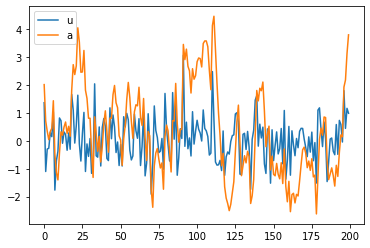

In [16]:
tfp_model.simulated.plot()
pass

ショック項`u`は細かく上下している一方，`a`は持続的に上昇もしくは減少し定常値`0`から乖離することがわかる。景気循環におけるマクロ変数の動きと似ていいる様に見えないだろうか。

### コメント

式[](eq:14-tfp)の両辺に対数をとると次式となる。

$$
\log(A_{t+1}) = \log(A_t) + u_{t+1}
$$

この式に基づいて次のようにしても結果は同じである

* ステップ３の(4)を次のコードと入れ替える。

    ```tfp = p['rho']*np.log(cur['a'])-np.log(fwd['a'])```
    
    
* ステップ６を

   ```tfp_model.approximate_and_solve(log_linear=False)```
   
   もしくは
   
   ```tfp_model.approximate_and_solve()```
   
   にする。ここで`log_linear`は対数線形近似をおこなうかどうかを設定する引数であり，デフォルトは`True`。`False`の場合は線形近似となる。

## 確率的ソロー・モデル

次の例としてTFPが確率的に変動するソロー・モデルを考えよう。均衡は次の３つの式で表される。

$$
Y_t = A_t K_t^{\alpha}
$$ (eq:14-prod_fn)

$$
K_{t+1} = sY_t + (1-d) K_t
$$ (eq:14-capital_accum)

$$
\log A_{t+1} = \rho \log A_t + u_{t+1}
$$ (eq:14-tfplog)

[](eq:14-tfplog)式は全要素生産性の変動を表しており，[](eq:14-tfp)式と同じである。また$u_{t}\sim\mathcal{N}(0,\sigma^2)$とする。

* ストック変数：$K_t$, $A_t$
* フロー変数：$Y_t$
* 内生変数：$K_t$, $A_t$, $Y_t$
* ショック変数：$u_t$

### ステップ１：パラメータの値

４つパラメータの値を入れた`Series`を変数`parameter`に割り当てる。

In [17]:
parameters = pd.Series({'alpha':0.36,
                        's':0.1,
                        'd':0.07,
                        'rho':0.551,
                        'sigma':0.0078**2})
parameters

alpha    0.360000
s        0.100000
d        0.070000
rho      0.551000
sigma    0.000061
dtype: float64

ここでは辞書を使って`Series`を作成している。`rho`と`sigma`の値は日本のTFPに関して計算した数値を設定している。

### ステップ２：変数リスト

内生変数名のリスをを作成する。その際，次の順番で並べる。
* ショック項が**ある**ストック変数（内生変数）の変数名
* ショック項が**ない**ストック変数（内生変数）の変数名
* フロー変数（他の内生変数）の変数名

また対数線形近似されることを念頭に小文字で変数名を設定することにする。

In [18]:
var_names = ['a','k','y']

次に，外生的ショックを表す変数名のリストを作成する。複数ある場合は，`var_names`と同じ順番に並べる。この例では，`a`のみにショック項があるので次のようにする。

In [19]:
shock_names = ['u']

### ステップ３：定常状態での均衡条件の関数

非確率的定常状態での値を返す関数を作成する。関数名は`equilibrium_equations`とする。この例での非確率的定常状態では次の条件を満たしている。

$$
A_{t+1}=A_t,\quad K_{t+1}=K_t\quad Y_{t+1}=Y_t\quad u_t=0
$$

* 引数：
    * `variables_forward`: $t+1$期（来期）の変数
    * `variables_current`: $t$期（当該期）の変数
    * ステップ１で設定したパラメータの値を含む`parameters`
* 返り値：
    * （非確率的）定常状態での内生変数の値を格納する`Numpy`の`array`

In [20]:
def equilibrium_equations(variables_forward, variables_current, parameters):
    
    fwd = variables_forward    #1
    
    cur = variables_current    #2    
    
    p = parameters             #3

    tfp = p['rho']*np.log(cur['a'])-np.log(fwd['a'])   #4
    
    production_function = cur['a']*cur['k']**p['alpha'] - cur['y']   #5
    
    capital_change = p['s']*cur['a']*cur['k']**p['alpha'] + \
                     (1-p['d'])*cur['k'] - fwd['k']              #6
    
    return np.array([tfp, production_function, capital_change])  #7

＜コードの説明＞
* `#1`： t+1期の変数を`fwd`に割り当てる。
* `#2`： t期の変数を`cur`に割り当てる。
* `#3`： ステップ１の`parameters`を`p`に割り当てる。
* `#4`： （非確率的）定常状態でのTFPの式を使い，左辺が0になるように整理し，その右辺を`tfp`に割り当てる。

    $$
    \begin{align*}
    \log(A_{t+1})
    &=\rho\log(A_t) \\
    &\Downarrow \\        
    0
    &=\rho\log(A_{t})-\log(A_{t+1})
    \end{align*}
    $$
    
    * ステップ４で`equilbirium_equations`関数を単に指定するだけだが， `linearmodels`は`cur`と`fwd`を`Series`として扱うことになるため，変数を`['a']`の形で指定する必要がある。

* `#5`： 生産関数の式を使い，左辺が0になるように整理し，その右辺を`production_function`に割り当てる。

    $$
    \begin{align*}
    Y_{t}&=A_tK_t^{a} \\
    &\Downarrow \\
    0&=A_tK_t^{a}-Y_t
    \end{align*}
    $$
    
    
* `#6`： 資本の蓄積方程式を使い，左辺が0になるように整理し，その右辺を`capital_change`に割り当てる。

    $$
    \begin{align*}
    K_{t+1}&=sA_tK_t^{a}+(1-d)K_t \\
    &\Downarrow \\
    0&=sA_tK_t^{a}+(1-d)K_t-K_{t+1}
    \end{align*}
    $$
    

* `#7`： `#4`〜`#6`の値を`array`として返す。

### ステップ４：モデルの最終準備（初期化）

`ls`の`model`という関数を使いシミュレーションの最終準備をおこない（初期化し），`solow_model`に割り当てる。
* 引数：
    * `equations`：ステップ３で定義した関数を指定する。
    * `n_states`：ストック変数の数を指定する。
        * （この例ではストック変数は`A`と`K`なので`2`を設定する。）
    * `n_exo_state`：ストック変数の中で外生的なショック項をともなう変数の数を指定する。
        * （この例ではストック変数`A`にショック項`u`が存在するので`1`を設定する。）
    * `var_names`：ステップ２で設定した内生変数のリストを指定する。
    * `shock_names`：ステップ２で設定したショック変数のリストを指定する。
    * `parameters`：ステップ１で設定したパラメータの値を含む`Series`を指定する。
    
* 戻り値：
    * `linearsolve`の`model`オブジェクトが返される。その中に様々な情報が含まれており，それを使いシミュレーションをおこなう。

In [21]:
solow_model = ls.model(equations = equilibrium_equations,
                       n_states=2,
                       n_exo_states=1,
                       var_names=var_names,
                       shock_names=shock_names,
                       parameters = parameters)

### ステップ５：定常状態の計算

最初に定常状態の値を確認しよう。`solow_model`のメソッド`compute_ss()`を使うと自動で計算してくれる。その際，引数に計算の初期値をリストとして与える。ステップ２で設定した`var_names`の順番に合わせて初期値を並べる。

In [22]:
solow_model.compute_ss([1,5,2])

上のコードを評価すると，`solow_model`には`.ss`という属性が追加され，それを使い計算結果を表示できる。

In [23]:
solow_model.ss

a    1.000000
k    1.745960
y    1.222172
dtype: float64

### ステップ６：モデルを対数線形近似

次にシミュレーションのための対数線形近似をおこなう。`solow_model`には`.approximate_and_solve()`というメソッドが用意されており，それを評価すると`solow_model`に対数線形近似の結果が追加される。

In [24]:
solow_model.approximate_and_solve()

In [25]:
print(solow_model.solved())

Solution to the log-linear system:

a[t+1] = 0.551·a[t]+u[t+1]

k[t+1] = 0.07·a[t]+0.9552·k[t]

  y[t] = a[t]+0.36·k[t]


ここで`a`，`k`，`y`は定常状態からの％乖離を表している。これらの式が「モデルを解いた結果」を示しており，次の特徴がある。
* ２つのストック変数（`a`と`k`）の`t+1`期の値は，`t`期の値と`t+1`期のショックに依存している。
* フロー変数の値はストック変数の値のみに依存しており，**Policy Function**と呼ばれる。

`t`期のストック変数と`t+1`期のショック変数の値が分かれば，`t+1`期の全ての変数の値が明らかになる体系になっている。例えば，`t=0`期が定常状態（`a[0]=k[0]=y[0]`）として`t=1`期にショック項`u[1]`が`1%`上昇したとしよう。上の式から`u[1]=a[1]=y[1]=1%`となることが分かる。

### ステップ７：シミュレーション結果の表示

#### インパルス反応

`t=0`期は定常状態で`a[0]=k[0]=y[0]=0`としよう。そして`t=1`期にショック項が`1％`上昇し（`u[1]=1%`），その後`0`に戻ると仮定しよう。この場合，
* `a[1]=y[1]=1%`であり，`k[1]=0`となる事が分かる。これがインパクト効果である。
* インパクト後，`a[2]=0.551・a[1]`，`k[2]=0.07・a[2]`，`y[2]=a[2]+0.35・k[2]`となり時間が経つに連れて変化することになる。

このインパルス反応を計算して図示してみよう。

#### インパルス反応の計算と図示

ホワイト・ノイズのショック$u_t$のインパルス反応を計算するには，`solow_model`のメソッド`impulse()`を使う。引数は次の３つとなる。
* `T`：シミュレーションのの期間
* `t0`：何期目にショックが発生するかを指定
* `shocks`：ショックの大きさ（％）（デフォルトは0.01）

In [26]:
solow_model.impulse(T=50, t0=5, percent=True)

計算結果は`solow_model`に辞書として追加される。
* キー：ショックの変数名`u`
* 値：ショック変数と内生変数の`DataFrame`

辞書は属性`.irs`でアクセスできるので，キー`u`を使い`DataFrame`を表示してみよう。

In [27]:
solow_model.irs['u'].head(9)

,u,a,k,y
0,0.0,0.000000,0.000000,0.000000
1,0.0,0.000000,0.000000,0.000000
2,0.0,0.000000,0.000000,0.000000
3,0.0,0.000000,0.000000,0.000000
4,0.0,0.000000,0.000000,0.000000
5,1.0,1.000000,0.000000,1.000000
6,0.0,0.551000,0.070000,0.576200
7,0.0,0.303601,0.105434,0.341557
8,0.0,0.167284,0.121963,0.211191


`5`番目の行で`u`は`1.0`になっている。同様に，`a`と`y`も`1.0`にジャンプしているが，資本ストックの％乖離である`k`は，`5`番目の行で`0`のままである。これは式[](eq:14-capital_accum)が示すように，`t`期の産出`Y`の変化は`t+1`期の資本ストックに影響を与えており，時間的なラグが発生しているためである。また`6`行目から`k`は徐々に増加していることがわかる。この結果は，資本ストックの変化には時間がかかるという特徴を反映したものといえる。

プロットしてみよう。

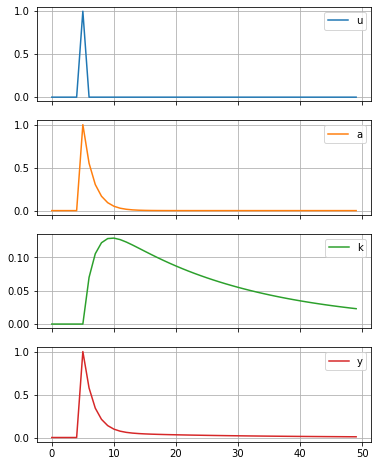

In [28]:
solow_model.irs['u'].plot(subplots=True, figsize=(6,8), grid=True)
pass

産出と資本ストックの％乖離の変化は大きく異なる。動物で例えると，産出はカモシカのように動きが素早いが，資本ストックは象のように動きがスローである。前者はフロー変数であり，後者はストック変数であるためであり，それぞれの変数の特徴が反映されたプロットとなっている。

#### コードを１つのセルにまとめる

ここでは上のコードを一つのセルにまとめて，全てを同時に実行し結果を表示してみよう。

定常値
a: 1.000
k: 1.746
y: 1.222

対数線形近似
a[t+1] = 0.551·a[t]+u[t+1]
k[t+1] = 0.07·a[t]+0.9552·k[t]
  y[t] = a[t]+0.36·k[t]


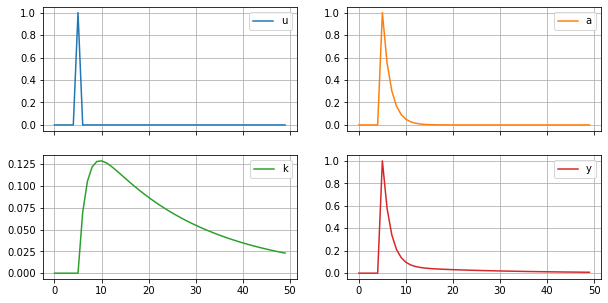

In [39]:
# パラメーターの値
parameters = pd.Series({'alpha':0.36,
                        's':0.1,
                        'd':0.07,
                        'rho':0.551,
                        'sigma':0.0078**2})

# 変数のリスト
var_names = ['a','k','y']
shock_names = ['u']

# 定常状態での均衡の関数
def equilibrium_equations(variables_forward, variables_current, parameters):    
    fwd = variables_forward
    cur = variables_current
    p = parameters
    
    tfp = p['rho']*np.log(cur['a'])-np.log(fwd['a'])
    
    production_function = cur['a']*cur['k']**p['alpha'] - cur['y']
    
    capital_change = p['s']*cur['a']*cur['k']**p['alpha'] + \
                     (1-p['d'])*cur['k'] - fwd['k']
    
    return np.array([tfp, production_function, capital_change])

# モデルの初期化
solow_model = ls.model(equations = equilibrium_equations,
                       n_states=2,
                       n_exo_states=1,
                       var_names=var_names,
                       shock_names=shock_names,
                       parameters = parameters)

# 定常状態の計算
solow_model.compute_ss([1,5,2])
print('定常値')
for i in range(len(solow_model.ss)):
    print(f'{solow_model.ss.index[i]}: {solow_model.ss[i]:.3f}')
print('')

# 対数線形近似
solow_model.approximate_and_solve()
print('対数線形近似')
for s in solow_model.solved().split('\n\n')[1:]:
    print(s, sep='')

# インパルス反応の計算
solow_model.impulse(T=50, t0=5, percent=True)

# プロット
solow_model.irs['u'].plot(subplots=True, layout=[2,2],
                          figsize=(10,5), grid=True)
pass

#### 確率的シミュレーション

次にメソッド`.stoch_sim()`を使って確率的シミュレーションをおこなってみよう。
* 主な引数：
    1. `seed` (オプション): `Numpy.random`を使いランダム変数を発生させるが，seedとはランダム変数の「種」という意味。`seed`に同じ数字を設定すると同じランダム変数が生成されることになる。
    1. `T`：シミュレーションの期間（デフォルトは51）
    1. `cov_mat`：ショック変数の分散共分散行列
        * ショック変数が１つの場合は分散を`[[0.5]]`のようにリストのリストで設定する。（デフォルトは`[[1]]`）
*　返り値：
    * なし
    * 結果は`solow_model`に`DataFrame`として追加され，属性`simulated`で抽出できる。

ショック項`u`の分散の値は0.0078であり，これは日本のTFPを推定した際の残差の分散である。この値を使ってシミュレーションをおこなおう。

In [29]:
solow_model.stoch_sim(seed=12345, T=200,
                      cov_mat=[parameters['sigma']],
                      percent=True)

結果の一部を表示してみる。

In [30]:
solow_model.simulated.head()

,u,a,k,y
0,1.362842,1.907869,-0.360161,1.778211
1,-1.099992,-0.048756,-0.210475,-0.124527
2,-0.295028,-0.321893,-0.204459,-0.395498
3,-0.269740,-0.447103,-0.217832,-0.525523
4,0.296449,0.050095,-0.239370,-0.036078


```{warning}
この`DataFrame`の値はランダム変数を発生させて計算した結果である。従って，引数`seed`を設定しない場合は，シミュレーションを実行する度に異なる結果が発生する。しかし，以下で示す表や値はシミュレーションを行うごとに異なる結果となるが，方向性としては概ね変わらない。
```

`DataFrame`を図示してみよう。

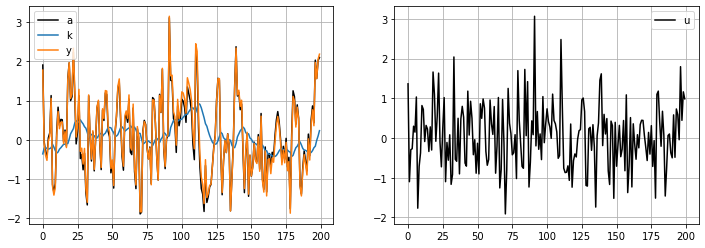

In [31]:
ax_ = solow_model.simulated[['a','u']].plot(subplots=True,
                                            layout=(1,2),
                                            grid=True,
                                            figsize=(12,4),
                                            color='k')
solow_model.simulated[['k','y']].plot(grid=True, ax=ax_[0,0])
pass

この図の特徴：
* `a`と`y`の動きは殆ど同じである。また上下の動きはが激しく，定常値`0`を跨いだ動きが多い。
* `k`の動きは緩やか。定常値`0`からの乖離の方向が比較的に長く持続する傾向にある。即ち，persistenceの特徴が強い。

変動の大きさを確認するために標準偏差を計算してみよう。

In [32]:
solow_model.simulated[['y','k','a']].std()

y    0.982764
k    0.308781
a    0.967536
dtype: float64

`a`と`y`の値はは殆ど同じである。一方，`k`の標準偏差は小さく，`a`と`y`の半分以下である。この特徴は相関係数からも確認できる。

In [33]:
solow_model.simulated[['y','k','a']].corr()

,y,k,a
y,1.000000,0.192482,0.993624
k,0.192482,1.000000,0.080621
a,0.993624,0.080621,1.000000


`y`と`a`の相関は非常に高く，`k`との相関は低い。また，３つの変数は正の相関があることがわかる。

次にpersistenceを考えてみよう。`k`の変動幅は小さいががpersistenceが大きいことが図から確認できる。実際に自己相関係数で確認してみよう。

In [34]:
var_list = ['y','k','a']

for v in var_list:
    ac = solow_model.simulated[v].autocorr()
    print(v,f': {ac:.3f}')

y : 0.554
k : 0.976
a : 0.528


`y`と`a`に比べて`k`の自己相関係数が非常に高いことがわかる。